In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# Определение VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # mean and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Для нормализации выходов
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))  # Преобразование в вектор
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Функция потерь
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            recon_batch, _, _ = model(data.view(-1, 784))
            break

    # Визуализация оригинальных и восстановленных изображений
    n = 20  # Количество изображений для отображения
    plt.figure(figsize=(12, 4))
    # Оригинальные изображения
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(data[i].view(28, 28).numpy(), cmap='gray')
        plt.axis('off')
    # Восстановленные изображения
    for i in range(n):
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

# Параметры
input_dim = 784  # 28x28 изображений
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 20
learning_rate = 1e-3

# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Инициализация модели и оптимизатора
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Epoch 1, Loss: 165.05671482747397
Epoch 2, Loss: 121.69260543619792
Epoch 3, Loss: 114.87577327473959
Epoch 4, Loss: 111.91900569661459
Epoch 5, Loss: 110.15789114583333
Epoch 6, Loss: 108.99312768554688
Epoch 7, Loss: 108.15619601236979
Epoch 8, Loss: 107.44767721354167
Epoch 9, Loss: 106.94766897786458
Epoch 10, Loss: 106.51981544596354
Epoch 11, Loss: 106.15348277994792
Epoch 12, Loss: 105.83806336263021
Epoch 13, Loss: 105.5377735514323
Epoch 14, Loss: 105.30019112955729
Epoch 15, Loss: 105.13857163085937
Epoch 16, Loss: 104.86236217447917
Epoch 17, Loss: 104.65665232747396
Epoch 18, Loss: 104.54272431640625
Epoch 19, Loss: 104.29692073567708
Epoch 20, Loss: 104.19598979492187
Обучение завершено!


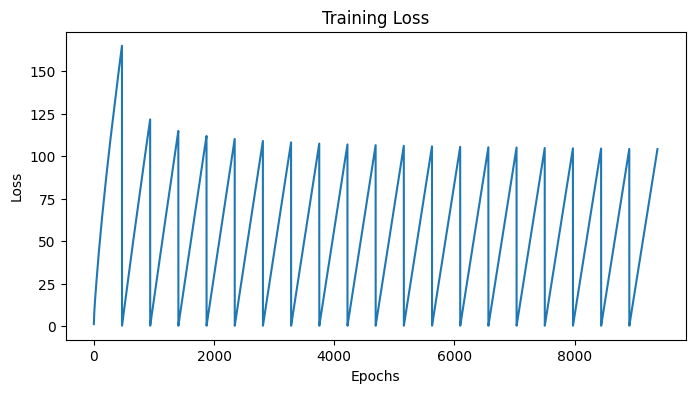

In [ ]:
# Обучение модели
model.train()
train_losses = []
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        '''
        if avg_loss < 101.0:
          break
          '''
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

print("Обучение завершено!")
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

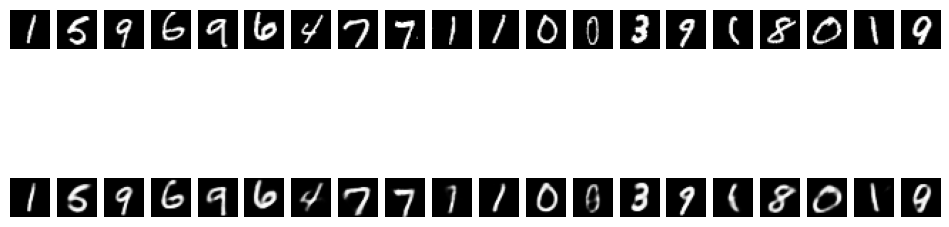

In [ ]:
# Визуализация оригинальных и восстановленных изображений после обучения
visualize_reconstruction(model, train_loader)

